This notebook studies the behavior of a group of 200 crystals over 3 years.

In [1]:
#import the stuff
import pandas as pd #dataframes etc
import matplotlib.pyplot as plt #plotting
import numpy as np
from sklearn import preprocessing
from common.utils import TimeSeriesTensor, create_evaluation_df, mape, scale_shrinker
#now lets try some autoregression
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.preprocessing import MinMaxScaler

In [2]:
test = pd.read_csv('/home/rusack/evans908/FAIR/scripts/slimmed_df_LME38_PNA4_2016.csv', index_col=0)
geom = pd.read_csv('/home/rusack/evans908/FAIR/ECAL_RADDAM_Data/geom/ecal_geom.csv', index_col=0)

/panfs/roc/msisoft/anaconda/python3-2020.07-mamba/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
test[['calibration']]

,calibration
54000,NaN
54000,NaN
54000,NaN
54000,NaN
54000,NaN
...,...
60849,0.910732
60849,NaN
60849,NaN
60849,NaN


In [4]:
def digest(grp):
    slimmed = grp[1][['calibration','laser_datetime']]
    return (grp[0], slimmed.set_index('laser_datetime'))

In [5]:
grps = [digest(grp) for grp in test.groupby(test.index)]

In [6]:
multi_df = grps[0][1].copy()
for grp in grps:
    multi_df[grp[0]] = grp[1].calibration
multi_df_clean = multi_df.drop('calibration',axis=1)

In [7]:
corr = multi_df_clean.corr()

In [8]:
corr.min().min()

0.5887321291345411

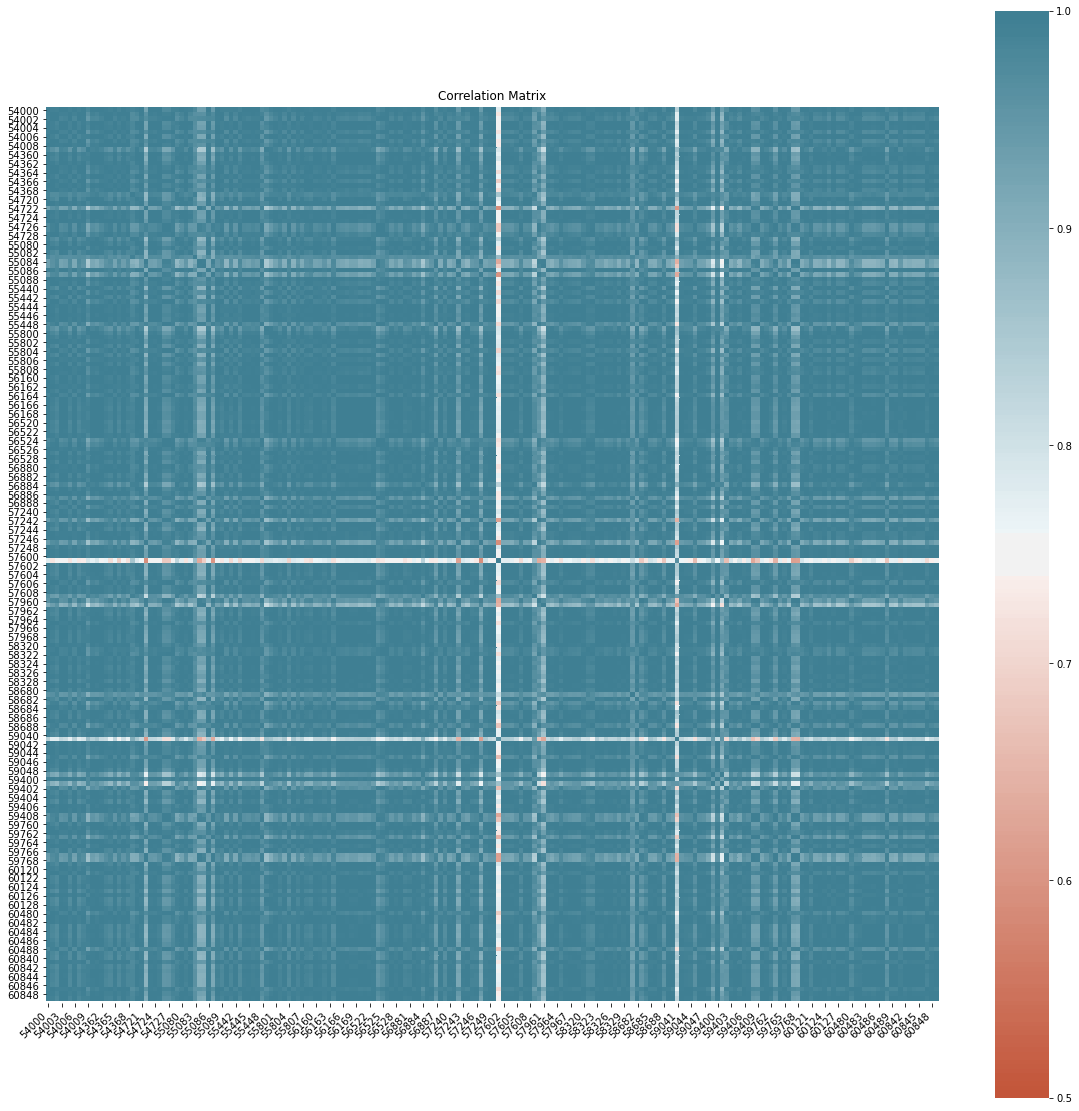

In [10]:
fig, ax = plt.subplots(figsize=(20,20))

ax.set_title('Correlation Matrix')
corr1 = multi_df_clean.corr()
ax = sns.heatmap(
    corr1, 
    vmin=0.50, vmax=1, center=0.75,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [11]:
corr1

,54000,54001,54002,54003,54004,54005,54006,54007,54008,54009,...,60840,60841,60842,60843,60844,60845,60846,60847,60848,60849
54000,1.000000,0.993903,0.989642,0.997795,0.997734,0.989956,0.997090,0.989063,0.996184,0.979965,...,0.991092,0.995677,0.991616,0.995336,0.994270,0.993565,0.993987,0.992825,0.996602,0.995606
54001,0.993903,1.000000,0.996363,0.993005,0.993914,0.998344,0.989382,0.997311,0.999057,0.960205,...,0.978289,0.997995,0.980808,0.986969,0.983327,0.982563,0.982376,0.998714,0.994440,0.989917
54002,0.989642,0.996363,1.000000,0.984237,0.986638,0.997881,0.979458,0.998214,0.995829,0.943609,...,0.964723,0.991689,0.969147,0.975608,0.971510,0.971246,0.971379,0.993431,0.985113,0.978392
54003,0.997795,0.993005,0.984237,1.000000,0.999190,0.986780,0.999237,0.985400,0.995037,0.985471,...,0.995217,0.996079,0.995939,0.998618,0.997402,0.997168,0.997033,0.993003,0.998898,0.998994
54004,0.997734,0.993914,0.986638,0.999190,1.000000,0.987774,0.997619,0.986376,0.996248,0.981132,...,0.992434,0.995897,0.995920,0.997442,0.995683,0.996416,0.996260,0.994077,0.998147,0.997323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60845,0.993565,0.982563,0.971246,0.997168,0.996416,0.973479,0.997694,0.971579,0.986850,0.991825,...,0.997878,0.988764,0.999468,0.999164,0.999245,1.000000,0.999770,0.983933,0.994816,0.997382
60846,0.993987,0.982376,0.971379,0.997033,0.996260,0.973205,0.997842,0.971228,0.986595,0.992379,...,0.998177,0.988613,0.999201,0.999196,0.999348,0.999770,1.000000,0.983832,0.994899,0.997340
60847,0.992825,0.998714,0.993431,0.993003,0.994077,0.996051,0.989504,0.994014,0.997976,0.961582,...,0.979882,0.998690,0.982607,0.988448,0.984778,0.983933,0.983832,1.000000,0.995534,0.991138
60848,0.996602,0.994440,0.985113,0.998898,0.998147,0.988501,0.998009,0.986662,0.995165,0.982209,...,0.993826,0.997750,0.993552,0.997640,0.995754,0.994816,0.994899,0.995534,1.000000,0.998872


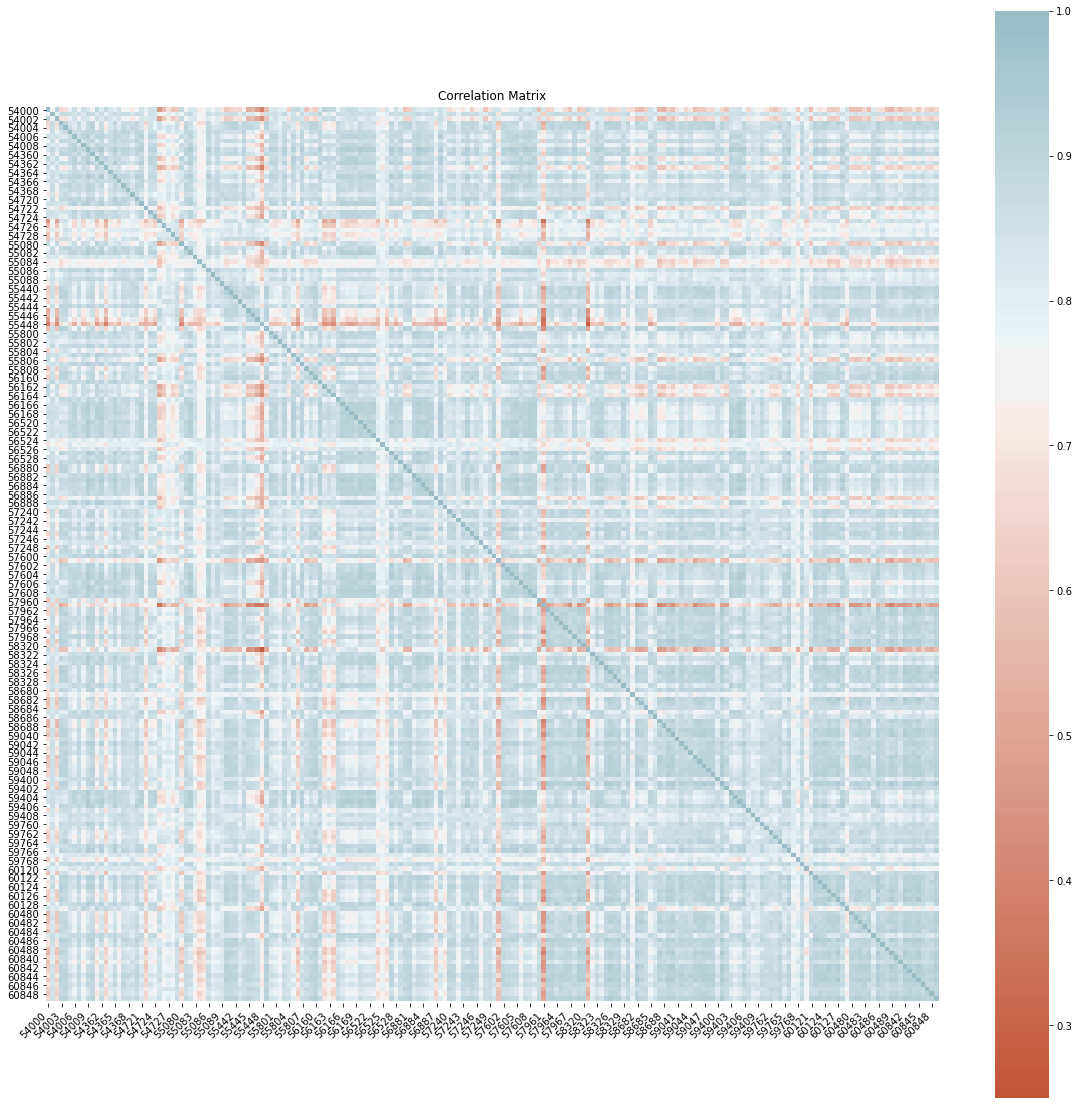

In [11]:
xtals_df = multi_df_clean
fig, ax = plt.subplots(figsize=(20,20))

ax.set_title('Correlation Matrix')
corr2 = xtals_df[(xtals_df.index > '2018-11-13 00:00:00') & (xtals_df.index < '2018-11-17 00:00:00')].corr()


ax = sns.heatmap(
    corr2, 
    vmin=0.25, vmax=1, center=0.75,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [12]:
corr2.min().min()

0.27322165256740194

In [13]:
geom

,cmsswId,dbID,hashedId,ix,iy,iz,FED,ccu,strip,Xtal,...,ieta,eta,PNA,PNB,Module,fabric,eta_module,phi_module,ieta_range,producer
0,838904321,1011191681,0,-85,1,0,610,65,5,1,...,-85,-1.478364,4,9,EB-1,1,-4.0,1,5,BCTP
1,838904322,1011191682,1,-85,2,0,610,65,5,2,...,-85,-1.478364,4,9,EB-1,1,-4.0,1,5,BCTP
2,838904323,1011191683,2,-85,3,0,610,65,5,3,...,-85,-1.478364,4,9,EB-1,1,-4.0,1,5,BCTP
3,838904324,1011191684,3,-85,4,0,610,65,5,4,...,-85,-1.478364,4,9,EB-1,1,-4.0,1,5,BCTP
4,838904325,1011191685,4,-85,5,0,610,65,5,5,...,-85,-1.478364,4,9,EB-1,1,-4.0,1,5,BCTP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75843,872438884,2012056100,14643,56,100,1,648,5,5,1,...,86,1.505265,50,45,EE+09,1,99.0,99,6,BCTP
75844,872439012,2012057100,14644,57,100,1,648,5,3,1,...,86,1.505265,50,45,EE+09,1,99.0,99,6,BCTP
75845,872439140,2012058100,14645,58,100,1,648,5,3,2,...,86,1.505265,50,45,EE+09,1,99.0,99,6,BCTP
75846,872439268,2012059100,14646,59,100,1,648,5,2,1,...,86,1.505265,50,45,EE+09,1,99.0,99,6,BCTP


In [14]:
corr2

,54000,54001,54002,54003,54004,54005,54006,54007,54008,54009,...,60840,60841,60842,60843,60844,60845,60846,60847,60848,60849
54000,1.000000,0.750137,0.903423,0.658996,0.677547,0.780900,0.864406,0.745440,0.854952,0.829848,...,0.645232,0.577056,0.621742,0.632600,0.698884,0.608536,0.697899,0.640195,0.615172,0.660261
54001,0.750137,1.000000,0.782111,0.870072,0.878541,0.866967,0.839567,0.869697,0.817462,0.883384,...,0.829183,0.801182,0.862446,0.835964,0.862824,0.849010,0.842921,0.861226,0.844070,0.857678
54002,0.903423,0.782111,1.000000,0.689270,0.691427,0.780285,0.860809,0.758780,0.842921,0.824713,...,0.648313,0.588318,0.637403,0.619952,0.696304,0.621650,0.687557,0.657604,0.620253,0.677415
54003,0.658996,0.870072,0.689270,1.000000,0.901568,0.840098,0.819740,0.890805,0.794369,0.883123,...,0.878182,0.845401,0.907797,0.900835,0.890265,0.925837,0.889172,0.874073,0.881116,0.898554
54004,0.677547,0.878541,0.691427,0.901568,1.000000,0.869901,0.814674,0.880639,0.798538,0.868289,...,0.878498,0.867681,0.888568,0.896480,0.905632,0.890736,0.893682,0.896936,0.887777,0.898553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60845,0.608536,0.849010,0.621650,0.925837,0.890736,0.842452,0.786713,0.870840,0.758319,0.866293,...,0.922334,0.874082,0.938758,0.932743,0.917893,1.000000,0.902922,0.893518,0.903637,0.927389
60846,0.697899,0.842921,0.687557,0.889172,0.893682,0.859823,0.828024,0.885156,0.814807,0.890798,...,0.887385,0.860627,0.906181,0.902079,0.912793,0.902922,1.000000,0.882819,0.875961,0.913103
60847,0.640195,0.861226,0.657604,0.874073,0.896936,0.852128,0.777929,0.864782,0.763731,0.843683,...,0.873831,0.860174,0.886909,0.897599,0.888063,0.893518,0.882819,1.000000,0.898809,0.893322
60848,0.615172,0.844070,0.620253,0.881116,0.887777,0.829450,0.771373,0.865804,0.738509,0.830303,...,0.899155,0.874915,0.891920,0.906388,0.889160,0.903637,0.875961,0.898809,1.000000,0.899610


In [15]:
geom.columns

Index(['cmsswId', 'dbID', 'hashedId', 'ix', 'iy', 'iz', 'FED', 'ccu', 'strip',
       'Xtal', 'elecID', 'side', 'LME', 'ieta', 'eta', 'PNA', 'PNB', 'Module',
       'fabric', 'eta_module', 'phi_module', 'ieta_range', 'producer'],
      dtype='object')

In [21]:
geom_var = 'eta'
sorted_columns = sorted(corr2.columns, key=lambda x: geom.loc[x,geom_var])

In [22]:
#import sys
#!{sys.executable} -m pip install pandas -U

In [30]:
corr2_sorted = corr2[sorted_columns]
corr2_dbl_sorted = corr2_sorted.sort_index(key=lambda x: geom.loc[x,geom_var])

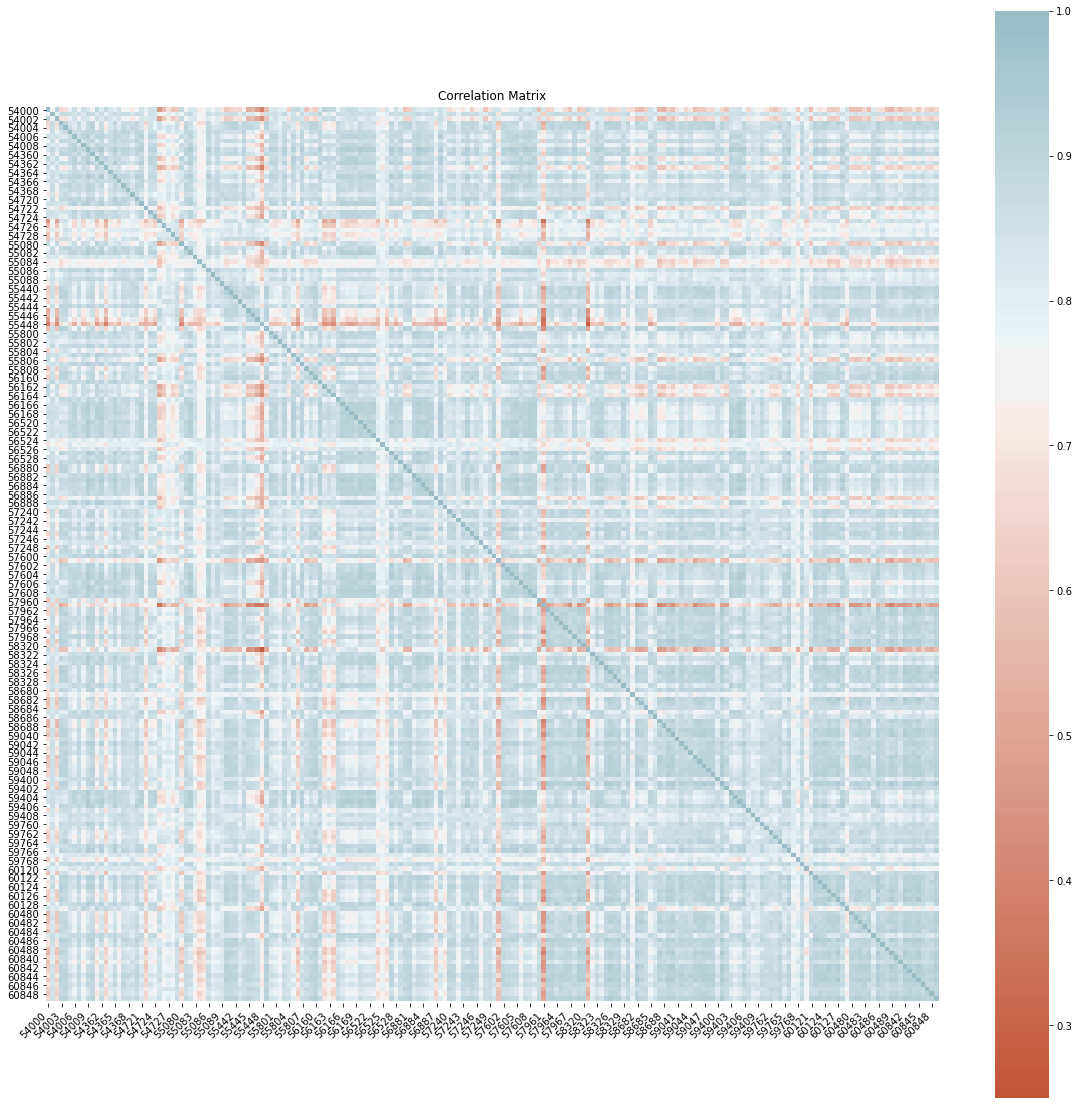

In [31]:
fig, ax = plt.subplots(figsize=(20,20))

ax.set_title('Correlation Matrix')



ax = sns.heatmap(
    corr2_dbl_sorted, 
    vmin=0.25, vmax=1, center=0.75,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
#fix for matplotlib 3.1.1 issue (fixed in 3.1.2??)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!